 02_model_comparison.ipynb
 -------------------------
 Purpose:
 - This notebook is focused on MODEL SELECTION, not raw data exploration.
 - It compares multiple regression models on the same dataset and decides
   which model is best, based on metrics and cross-validation.

 What this notebook does:
 1. Load the cleaned features and target:
    - Uses build_features(df) to get X (features) and y (target).
    - This ensures we use the same feature logic as the rest of the project.
 2. Create a train/test split:
    - Uses train_test_split_xy(X, y) from the shared features module.
    - Train set: used to fit the models.
    - Test set: used to evaluate generalisation on unseen data.
 3. Apply a log-transform to the target for modelling:
    - We model log(price) instead of price directly to:
        - Reduce skew in the target.
        - Stabilise variance (reduce heteroscedasticity).
        - Improve linear model assumptions.
    - Models are fit on log(y), but evaluation is done back in original price units.
 4. Define and compare multiple models:
    - Linear Regression (plain OLS).
    - Ridge Regression (L2 regularisation).
    - Lasso Regression (L1 regularisation).
    - Each model is wrapped in a Pipeline with:
        - "preprocess": build_feature_pipeline() (handles numeric + categorical).
        - "model": the chosen regressor.
 5. Evaluate models on the test set:
    - For each model:
        - Fit on X_train, log(y_train).
        - Predict on X_test, get log predictions.
        - Exponentiate predictions back to price scale.
        - Compute regression metrics (MAE, MSE, RMSE, R2) in price units.
    - Store results in a DataFrame for side-by-side comparison.
 6. Evaluate models with cross-validation:
    - Use cross_val_score with a log-target to compute CV RMSE.
    - This gives a more stable comparison than a single train/test split.
    - Helps avoid overfitting to one particular split.
 7. Select a "best" model:
    - Based on RMSE, MAE, R2, and CV RMSE.
    - In this project, Ridge typically wins because:
        - The data has very strong multicollinearity between numeric features.
        - Ridge shrinks coefficients and stabilises the model.
 8. Do basic diagnostics on the chosen model:
    - For the selected model (e.g. Ridge):
        - Predict on the test set (in price units).
        - Plot residuals vs predicted price.
        - Plot residual histogram.
        - Plot Q-Q plot of residuals.
    - These quick checks confirm that the chosen model behaves sensibly.

 What this notebook does NOT do:
 - It does NOT re-do general EDA (no df.info, df.describe, general histograms).
 - It does NOT finalise interpretation or production deployment.

 How this notebook fits into the overall workflow:
 - 01_exploration.ipynb tells us what the data looks like.
 - 02_model_comparison.ipynb tells us which type of model works best
   (Linear vs Ridge vs Lasso) and with what settings (e.g. alpha).
 - Once a best model is chosen (e.g. Ridge on log(price)), that choice is
   reflected in the project code (e.g. MODEL_REGISTRY in train.py).
 - Detailed diagnostics and interpretability for the final chosen model
   are handled in 03_model_diagnostics.ipynb.


In [1]:
import sys
import os

# Make src/ importable
project_root = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(project_root, "src"))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from spend_model.data_load import load_raw_data
from spend_model.features import (
    NUMERIC_FEATURES,
    CATEGORICAL_FEATURES,
    TARGET_COL,
    build_features,
    build_feature_pipeline,
    train_test_split_xy,
)
from spend_model.evaluation import regression_metrics

In [2]:
df = load_raw_data()
X, y = build_features(df)

print("Shape:", X.shape)
display(X.head())
print("\nTarget preview:")
display(y.head())

Shape: (205, 25)


,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,...,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_brand
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,...,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,alfa-romero
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,...,gas,std,four,sedan,fwd,front,ohc,four,mpfi,audi
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,...,gas,std,four,sedan,4wd,front,ohc,five,mpfi,audi



Target preview:


0    13495.0
1    16500.0
2    16500.0
3    13950.0
4    17450.0
Name: price, dtype: float64

In [3]:
print(df.shape)

(205, 26)


In [4]:
X_train, X_test, y_train, y_test = train_test_split_xy(X, y)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (164, 25)
Test shape : (41, 25)


In [5]:
def evaluate_model(pipeline: Pipeline, X_train, X_test, y_train, y_test):
    """
    Fit model on log(target) and evaluate in original price units.
    """
    y_train_log = np.log(y_train)

    # Fit model on log(price)
    pipeline.fit(X_train, y_train_log)

    # Predict log(price) then invert to price
    y_pred_log = pipeline.predict(X_test)
    y_pred = np.exp(y_pred_log)

    # Metrics in original price scale
    return regression_metrics(y_test, y_pred), y_pred


def cv_rmse(pipeline: Pipeline, X, y, folds: int = 5) -> float:
    """
    Cross-validated RMSE in log-price space.
    """
    y_log = np.log(y)
    scores = cross_val_score(
        pipeline,
        X,
        y_log,
        scoring="neg_root_mean_squared_error",
        cv=folds,
    )
    return -scores.mean()


In [6]:
pipelines = {
    "Linear": Pipeline([
        ("preprocess", build_feature_pipeline()),
        ("model", LinearRegression()),
    ]),
    "Ridge": Pipeline([
        ("preprocess", build_feature_pipeline()),
        ("model", Ridge(alpha=10.0)),
    ]),
    "Lasso": Pipeline([
        ("preprocess", build_feature_pipeline()),
        ("model", Lasso(alpha=0.001)),
    ]),
    "RandomForest": Pipeline([
        ("preprocess", build_feature_pipeline()),
        ("model", RandomForestRegressor(
            n_estimators=500,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=42,
        )),
    ]),
}

In [7]:
results = {}
y_pred_store = {}

for name, pipe in pipelines.items():
    print(f"Training {name}...")
    metrics, y_pred = evaluate_model(pipe, X_train, X_test, y_train, y_test)
    results[name] = metrics
    y_pred_store[name] = y_pred

results_df = pd.DataFrame(results).T
results_df

Training Linear...
Training Ridge...
Training Lasso...
Training RandomForest...


,MAE,MSE,RMSE,R2
Linear,2122.033917,1.018096e+07,3190.761112,0.871036
Ridge,1503.533636,5.409242e+06,2325.777629,0.931480
Lasso,1398.313260,3.845441e+06,1960.979529,0.951289
RandomForest,1360.894710,3.586716e+06,1893.862773,0.954566


In [8]:
cv_results = {}

for name, pipe in pipelines.items():
    print(f"CV for {name}...")
    cv_results[name] = cv_rmse(pipe, X, y, folds=5)

pd.DataFrame(cv_results, index=["CV_RMSE"]).T

CV for Linear...
CV for Ridge...
CV for Lasso...
CV for RandomForest...


,CV_RMSE
Linear,0.404230
Ridge,0.206212
Lasso,0.226527
RandomForest,0.213711


In [15]:
best_name = "RandomForest"
best_pipeline = pipelines[best_name]

# Refit best model on full training data
y_train_log = np.log(y_train)
best_pipeline.fit(X_train, y_train_log)

# Predictions on test set
y_pred_log_best = best_pipeline.predict(X_test)
y_pred_best = np.exp(y_pred_log_best)
residuals = y_test - y_pred_best

print(f"Best model: {best_name}")
regression_metrics(y_test, y_pred_best)

Best model: RandomForest


{'MAE': 1360.8947096996988,
 'MSE': 3586716.2047139714,
 'RMSE': np.float64(1893.8627734643214),
 'R2': 0.9545663349200116}

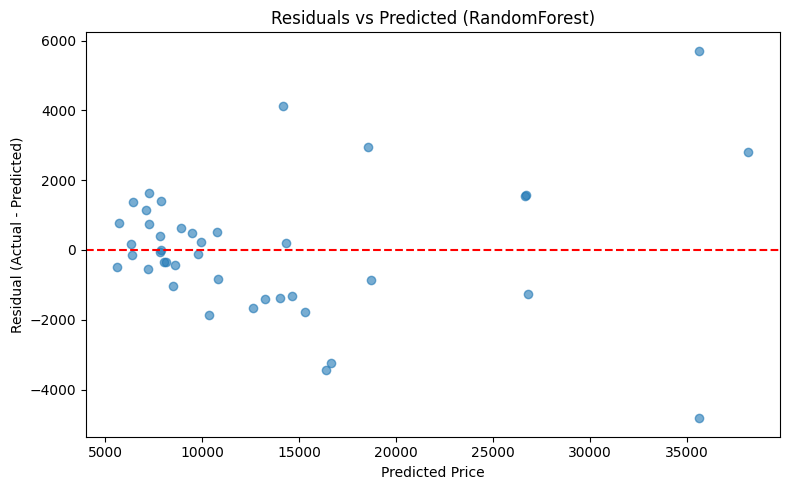

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.tight_layout()
plt.show()

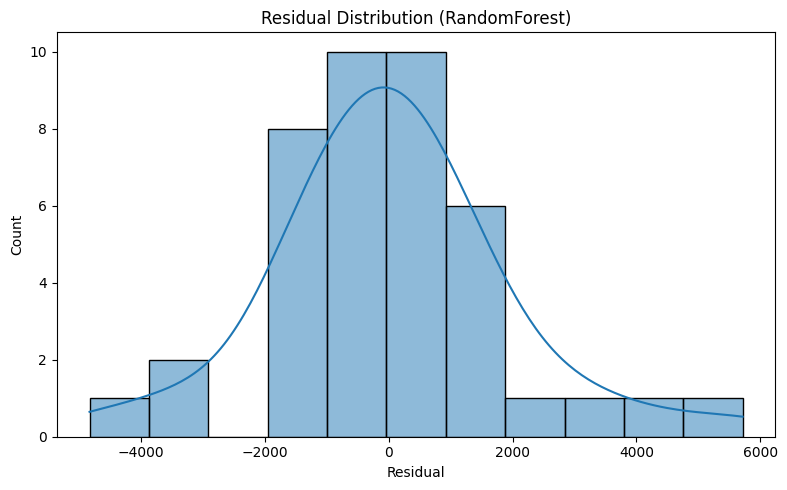

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title(f"Residual Distribution ({best_name})")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

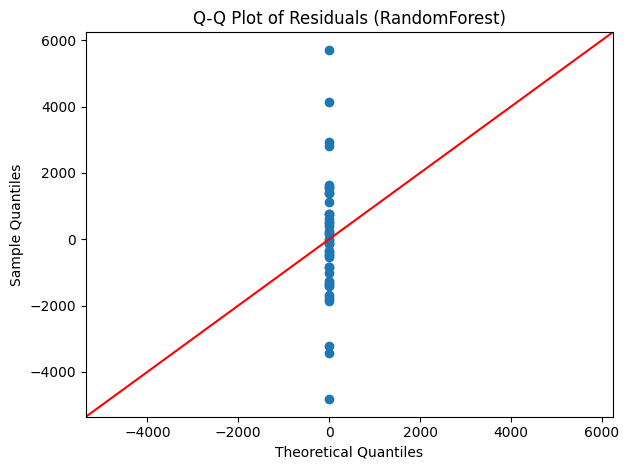

In [18]:
plt.figure(figsize=(5, 5))
sm.qqplot(residuals, line="45")
plt.title(f"Q-Q Plot of Residuals ({best_name})")
plt.tight_layout()
plt.show()

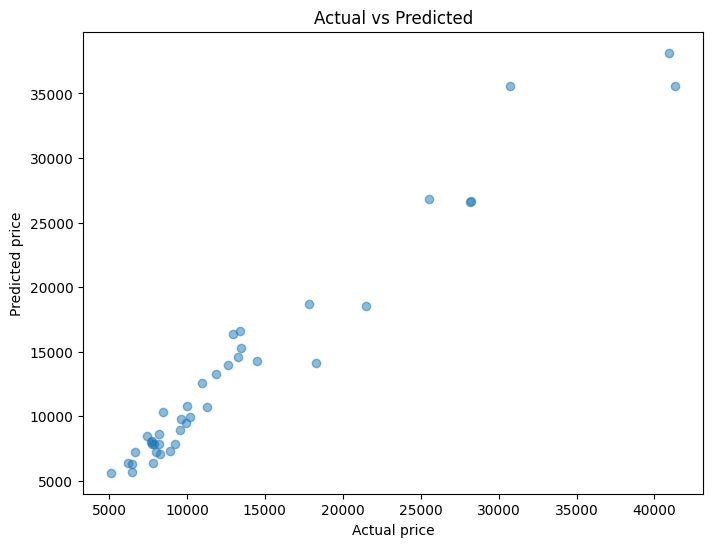

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)

plt.xlabel("Actual " + TARGET_COL)
plt.ylabel("Predicted " + TARGET_COL)
plt.title("Actual vs Predicted")
plt.show()